### 온열질환자 구간에 따른 Classification 모델 생성

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
import os
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectPercentile
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from itertools import cycle

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [3]:
# 나눔 폰트 경로 설정
# dir = '/data1/E382/hwchoi/00.data/00.preprocessing'
dir='C:/Windows/Fonts'
font_path = os.path.join(dir, 'NANUMGOTHIC.TTF')
# font_path = os.path.join(dir, 'DejaVu Sans')

# 폰트 속성 설정
fontprop = fm.FontProperties(fname=font_path, size=10)


# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)

# Matplotlib 폰트 캐시 파일 삭제 (필요시 사용)
cache_dir = os.path.expanduser('~/.cache/matplotlib')
font_cache_path = os.path.join(cache_dir, 'fontlist-v330.json')
if os.path.exists(font_cache_path):
    os.remove(font_cache_path)

# 폰트를 matplotlib에 설정
plt.rc('font', family=fontprop.get_name())

###  MODELING

### DecisionTree, RandomForest, XGBoost 데이터 셋 재정리

In [4]:
path='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_0812.csv'
df=pd.read_csv(path)
df.head(2)

,sido,create_date,sido_cd,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,...,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,jenks_cluster,instDate,updtDate
0,경기도,2014-05-01,31,0,60,120,0.0,0.0,9.6,24.2,...,21,24,22,14,21,17,0,0,2024-07-31,2024-07-31
1,충청북도,2014-05-01,33,0,69,107,0.0,0.0,10.5,23.7,...,21,23,22,15,22,18,0,0,2024-07-31,2024-07-31


In [5]:
### binary classification
df['binary_cluster'] = df['jenks_cluster'].apply(lambda x: 0 if x == 0 else 1)
print('binary 0/1 건수: ', df.groupby('binary_cluster').size())
print('multi 0/1/2 건수: ', df.groupby('jenks_cluster').size())

binary 0/1 건수:  binary_cluster
0    19974
1     6036
dtype: int64
multi 0/1/2 건수:  jenks_cluster
0    19974
1     5538
2      498
dtype: int64


In [6]:
# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

In [7]:
features=['weekend_yn', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm', 'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp', 'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days',
       'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man', 'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1',
       'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2']
# features=['max_ta', 'mean_ta', 'max_tafeel', 'ta_max_am', 'ta_max_pm', 'ta_mean_pm', 'ta_max_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1','ta_mean_six_pm1']
target='jenks_cluster'
print(len(features))

48


In [8]:
X=df[features]
y=df[target]
# 언더샘플링 적용
# undersample = RandomUnderSampler(sampling_strategy='not minority', random_state=42)
# X_resampled, y_resampled = undersample.fit_resample(X, y)

In [9]:
# 기본 모델(RandomForest, XGBoost)
# 학습 데이터와 테스트 데이터로 분할
# 데이터 스케일링
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=11, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
print(y_train.value_counts())
print(y_test.value_counts())

jenks_cluster
0    15984
1     4431
2      393
Name: count, dtype: int64
jenks_cluster
0    3990
1    1107
2     105
Name: count, dtype: int64


In [11]:
def plot_confusion_matrix(conf_matrix, model_name, accuracy):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix\nAccuracy: {accuracy:.2f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [12]:
performance_list = []
num_classes = 3


def evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    confusion = confusion_matrix(y_test, y_pred)
    
    for cls in range(num_classes):
        cls = str(cls)
        performance_list.append({
            'Model': model_name,
            'Class': cls,
            'Accuracy': accuracy,
            'Precision': report[cls]['precision'],
            'Recall': report[cls]['recall'],
            'F1-Score': report[cls]['f1-score'],
            'Support': report[cls]['support']
        })
    
    plot_confusion_matrix(confusion, model_name, accuracy)

In [13]:
# Decision Tree 
# dt_classifier = DecisionTreeClassifier(random_state=11)
# evaluate_model(dt_classifier, 'Decision Tree')

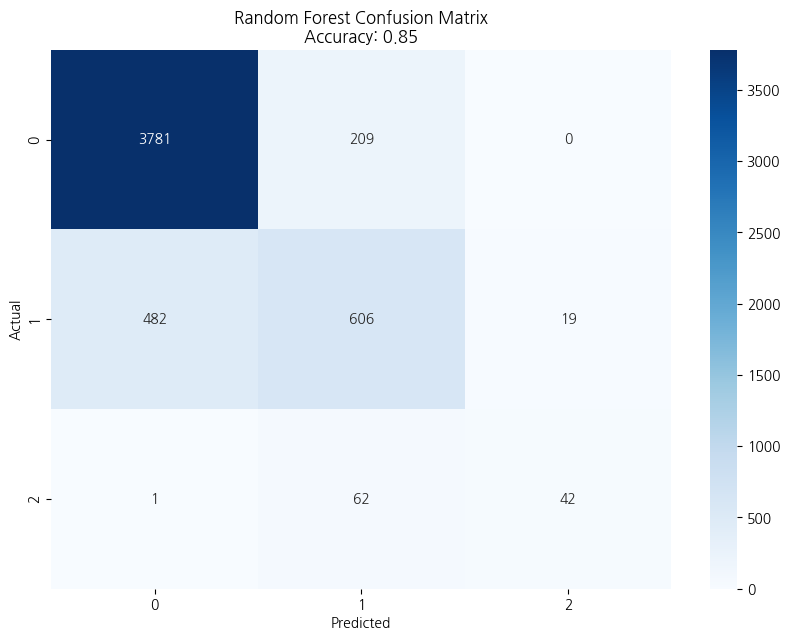

In [14]:
# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=60, random_state=11)
evaluate_model(rf_classifier, 'Random Forest')

In [15]:
# SVM
# svm_classifier = SVC(kernel='linear', random_state=11)
# evaluate_model(svm_classifier, 'SVM')

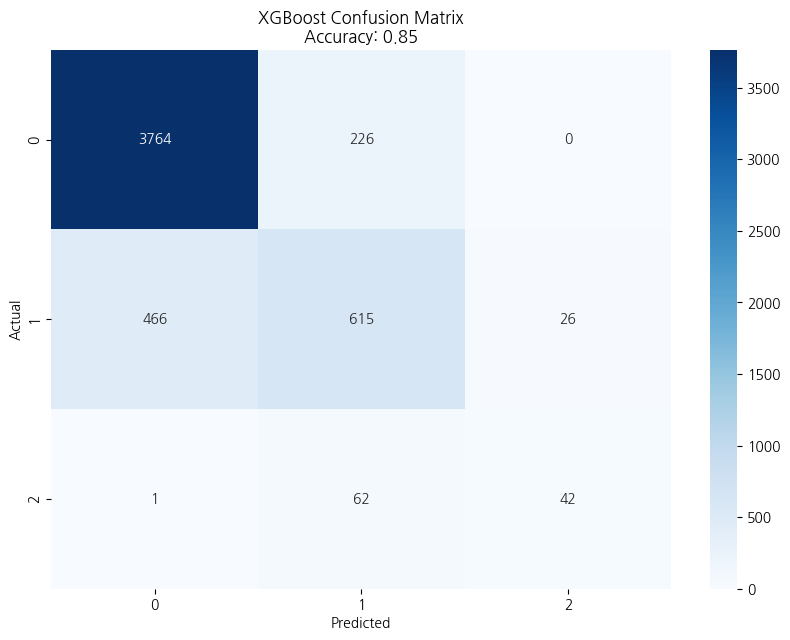

In [16]:
# XGBoost
xgb_classifier = XGBClassifier(eval_metric='logloss', random_state=11)
evaluate_model(xgb_classifier, 'XGBoost')

In [17]:
# 성능 데이터프레임 생성
performance_df = pd.DataFrame(performance_list)
print(performance_df)

           Model Class  Accuracy  Precision    Recall  F1-Score  Support
0  Random Forest     0  0.851403   0.886726  0.947619  0.916162   3990.0
1  Random Forest     1  0.851403   0.690992  0.547425  0.610887   1107.0
2  Random Forest     2  0.851403   0.688525  0.400000  0.506024    105.0
3        XGBoost     0  0.849865   0.889624  0.943358  0.915704   3990.0
4        XGBoost     1  0.849865   0.681063  0.555556  0.611940   1107.0
5        XGBoost     2  0.849865   0.617647  0.400000  0.485549    105.0


In [18]:
# performance_df.to_csv('D:/Work/001.project/003.kdca/004.실험/performance_jenkins_v03.csv', index=False, encoding='utf-8-sig')

### SHAP을 이용한 feature select

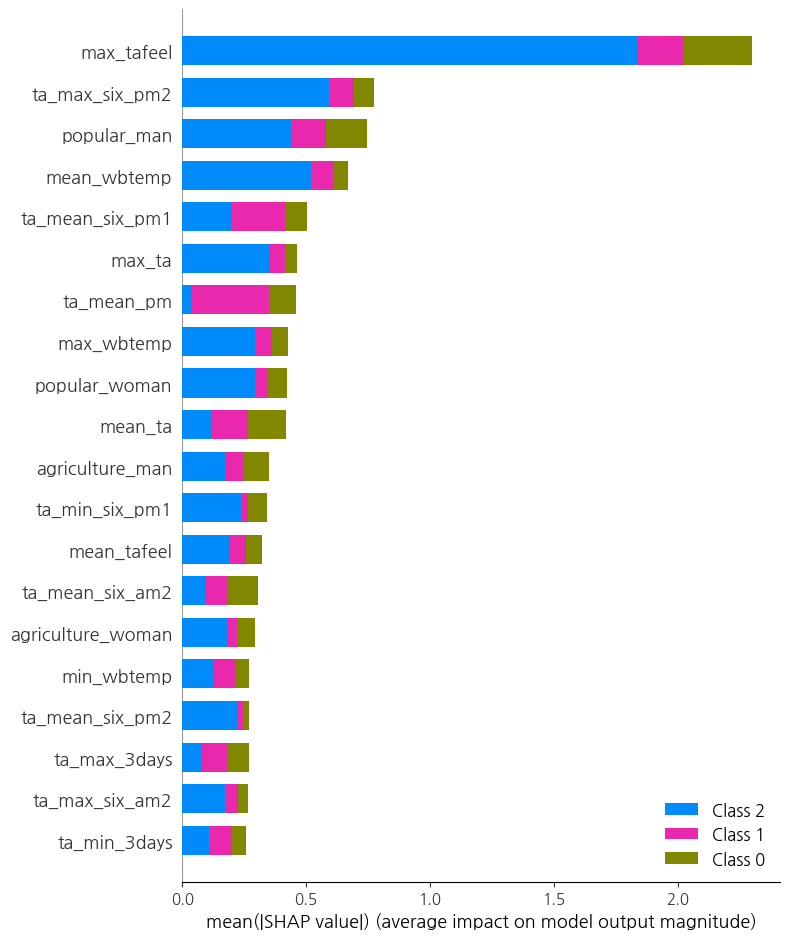

In [19]:
# SHAP Explainer 초기화 및 SHAP 값 계산
explainer = shap.Explainer(xgb_classifier)
shap_values = explainer.shap_values(X_test)

# SHAP summary plot을 그리면서 feature 이름을 명시
shap.summary_plot(shap_values, X_test, feature_names=features)

In [20]:
shap_values_class_1 = shap_values[1]  # 클래스 1에 해당하는 SHAP 값
shap_values_class_2 = shap_values[2]  # 클래스 2에 해당하는 SHAP 값

In [21]:
shap_importance_class_1 = np.mean(np.abs(shap_values_class_1), axis=0)
shap_importance_class_2 = np.mean(np.abs(shap_values_class_2), axis=0)

# 데이터프레임으로 정리
shap_importance_df_class_1 = pd.DataFrame({
    'feature': features,
    'importance': shap_importance_class_1
})

# 중요도 순으로 정렬
# TOP15개만 저장
shap_importance_df_class_1 = shap_importance_df_class_1.sort_values(by='importance', ascending=False).reset_index(drop=True).head(15)


# 데이터프레임으로 정리
shap_importance_df_class_2 = pd.DataFrame({
    'feature': features,
    'importance': shap_importance_class_2
})

# 중요도 순으로 정렬
# TOP15개만 저장
shap_importance_df_class_2 = shap_importance_df_class_2.sort_values(by='importance', ascending=False).reset_index(drop=True).head(15)

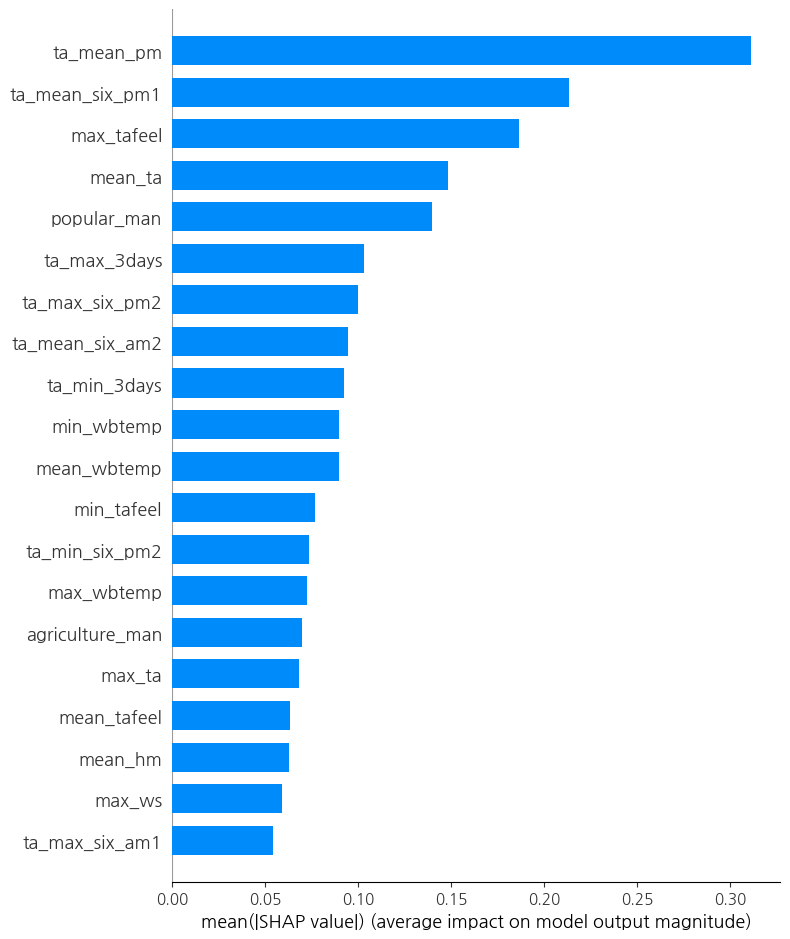

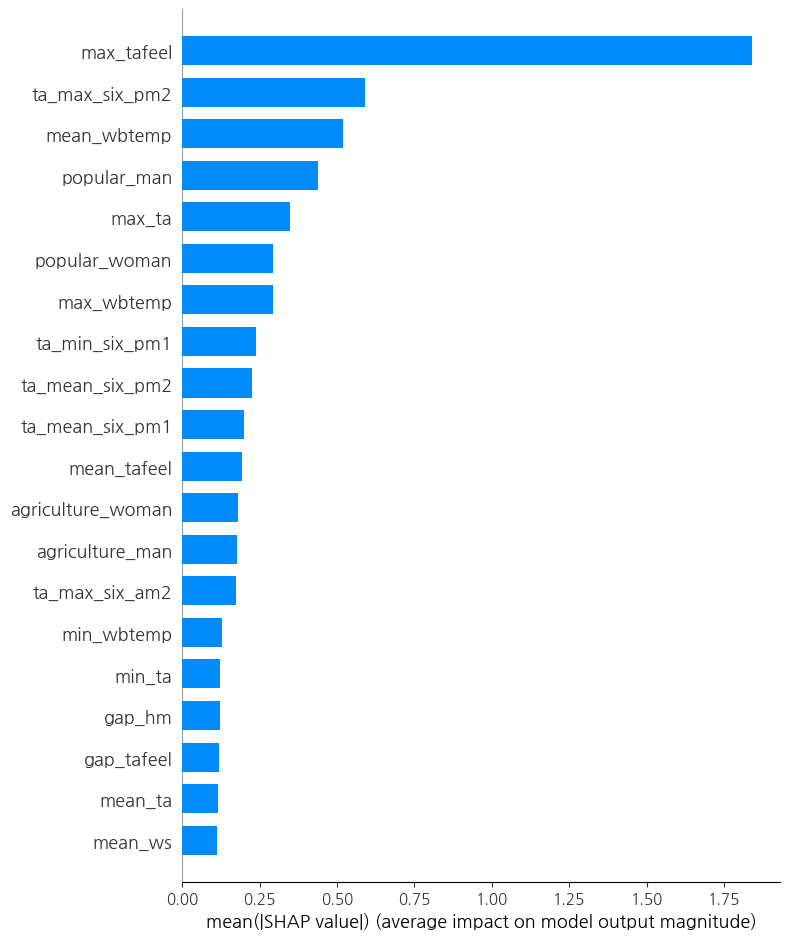

In [22]:
# 클래스 1의 SHAP summary plot
shap_class1=shap.summary_plot(shap_values_class_1, X_test, feature_names=features, plot_type="bar", class_names=["Class 1"])

# 클래스 2의 SHAP summary plot
shap_class2=shap.summary_plot(shap_values_class_2, X_test, feature_names=features, plot_type="bar", class_names=["Class 2"])

Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


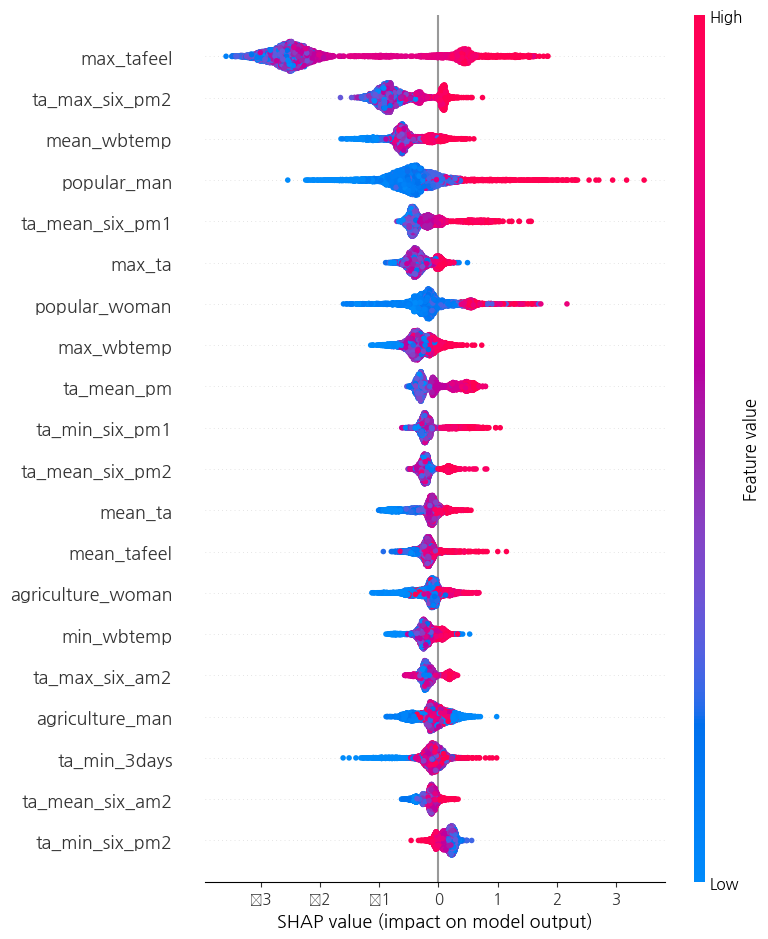

In [23]:
# 클래스 1과 2를 합산한 summary plot
shap_values_combined = shap_values_class_1 + shap_values_class_2
# 플롯 크기 조정
plt.figure(figsize=(10, 6))  # 가로 10, 세로 6의 크기로 조정
shap.summary_plot(shap_values_combined, X_test, feature_names=features)

### SHAP을 이용해 추출한 TOP15개 feature를 이용한 분류 모델링 (Classifier)

In [24]:
def plot_confusion_matrix(conf_matrix, model_name, accuracy):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix\nAccuracy: {accuracy:.2f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [25]:
performance_list = []
num_classes = 3


def evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    confusion = confusion_matrix(y_test, y_pred)
    
    for cls in range(num_classes):
        cls = str(cls)
        performance_list.append({
            'Model': model_name,
            'Class': cls,
            'Accuracy': accuracy,
            'Precision': report[cls]['precision'],
            'Recall': report[cls]['recall'],
            'F1-Score': report[cls]['f1-score'],
            'Support': report[cls]['support']
        })
    
    plot_confusion_matrix(confusion, model_name, accuracy)

#### SHAP class1을 적용한 모델링

In [38]:
path='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_0812.csv'
df=pd.read_csv(path)
df.head(2)

# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

# class 1에 적합한 feature 리스트
features=list(shap_importance_df_class_1['feature'].values)
target='jenks_cluster'
print(len(features))


X=df[features]
y=df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

15


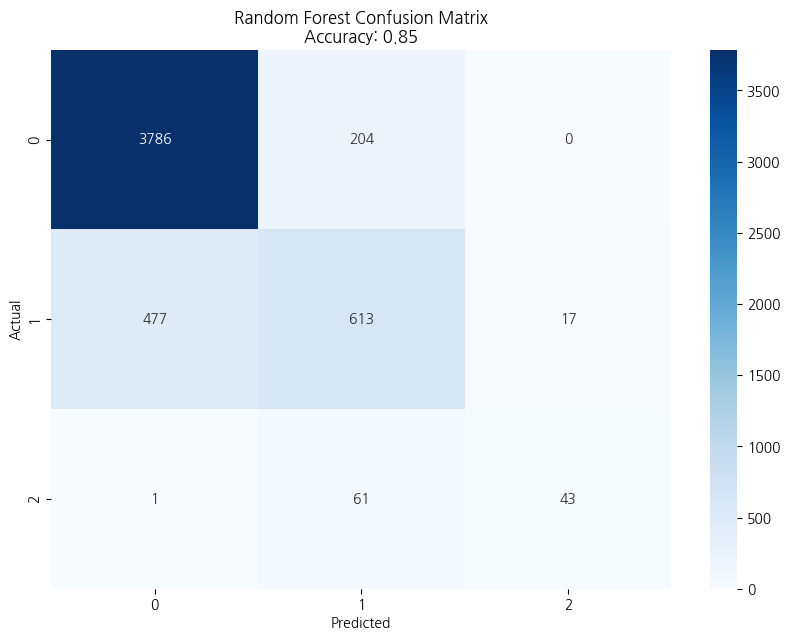

In [39]:
# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=60, random_state=11)
evaluate_model(rf_classifier, 'Random Forest')

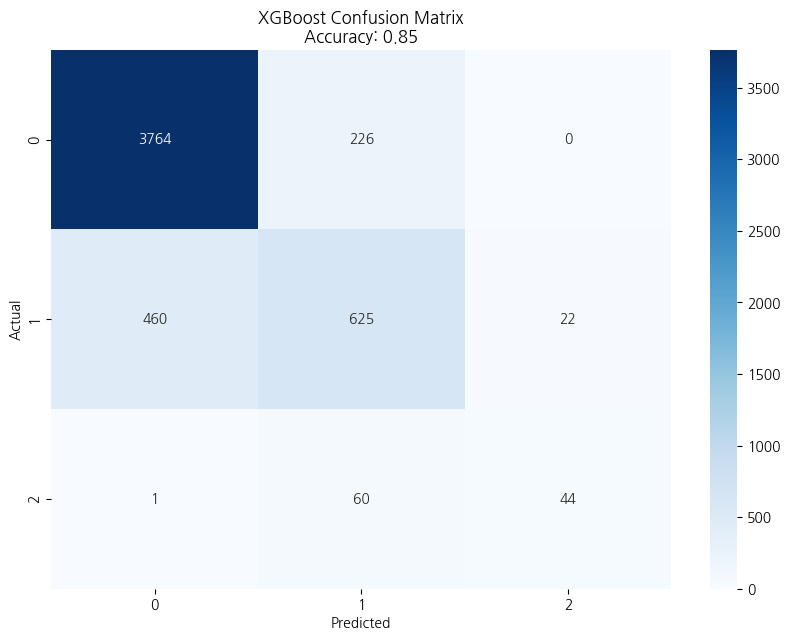

In [40]:
# XGBoost
xgb_classifier = XGBClassifier(eval_metric='logloss', random_state=11)
evaluate_model(xgb_classifier, 'XGBoost')

In [41]:
# 성능 데이터프레임 생성
performance_class1 = pd.DataFrame(performance_list)
print(performance_class1)

           Model Class  Accuracy  Precision    Recall  F1-Score  Support
0  Random Forest     0  0.853902   0.887899  0.948872  0.917373   3990.0
1  Random Forest     1  0.853902   0.698178  0.553749  0.617632   1107.0
2  Random Forest     2  0.853902   0.716667  0.409524  0.521212    105.0
3        XGBoost     0  0.852172   0.890888  0.943358  0.916372   3990.0
4        XGBoost     1  0.852172   0.686059  0.564589  0.619425   1107.0
5        XGBoost     2  0.852172   0.666667  0.419048  0.514620    105.0


#### SHAP class2을 적용한 모델링

In [66]:
path='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_0812.csv'
df=pd.read_csv(path)
df.head(2)

performance_list = []

# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

# class 1에 적합한 feature 리스트
features=list(shap_importance_df_class_2['feature'].values)
target='jenks_cluster'
print(len(features))

X=df[features]
y=df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

15


In [67]:
features

['max_tafeel',
 'ta_max_six_pm2',
 'mean_wbtemp',
 'popular_man',
 'max_ta',
 'popular_woman',
 'max_wbtemp',
 'ta_min_six_pm1',
 'ta_mean_six_pm2',
 'ta_mean_six_pm1',
 'mean_tafeel',
 'agriculture_woman',
 'agriculture_man',
 'ta_max_six_am2',
 'min_wbtemp']

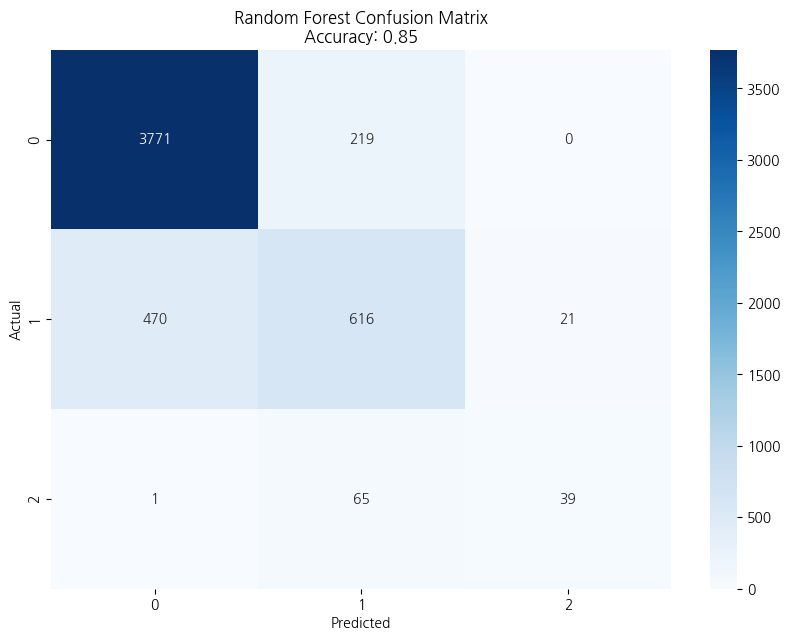

In [59]:
# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=60, random_state=11)
evaluate_model(rf_classifier, 'Random Forest')

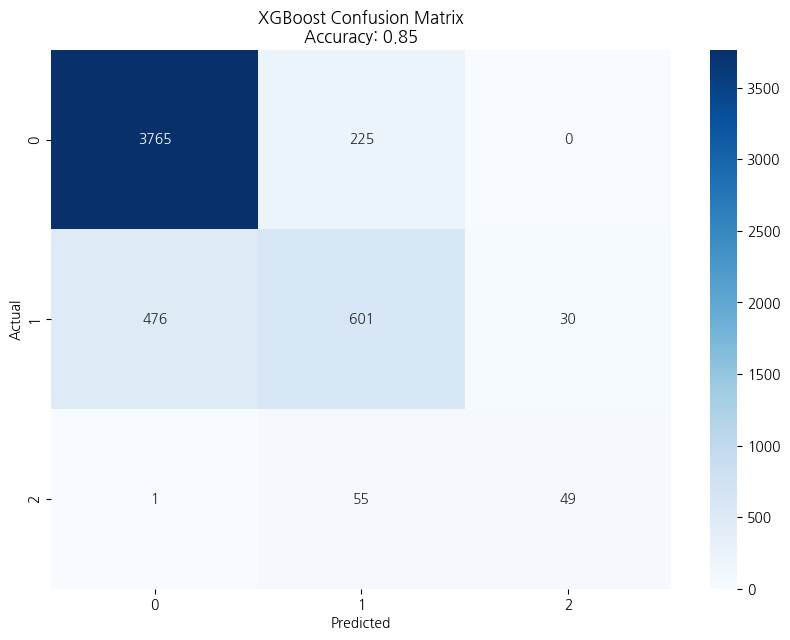

In [60]:
# XGBoost
xgb_classifier = XGBClassifier(eval_metric='logloss', random_state=11)
evaluate_model(xgb_classifier, 'XGBoost')

In [61]:
# 성능 데이터프레임 생성
performance_class2 = pd.DataFrame(performance_list)
print(performance_class2)

           Model Class  Accuracy  Precision    Recall  F1-Score  Support
0  Random Forest     0  0.850827   0.888967  0.945113  0.916181   3990.0
1  Random Forest     1  0.850827   0.684444  0.556459  0.613852   1107.0
2  Random Forest     2  0.850827   0.650000  0.371429  0.472727    105.0
3        XGBoost     0  0.848712   0.887553  0.943609  0.914723   3990.0
4        XGBoost     1  0.848712   0.682179  0.542909  0.604628   1107.0
5        XGBoost     2  0.848712   0.620253  0.466667  0.532609    105.0


#### SHAP class1 & class2을 적용한 모델링

In [26]:
path='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_0812.csv'
df=pd.read_csv(path)
df.head(2)

performance_list = []

# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

# class 1에 적합한 feature 리스트
features=features=['max_tafeel', 'ta_max_six_pm2', 'mean_wbtemp', 'popular_man', 'ta_mean_six_pm1' , 'max_ta', 'popular_woman', 'max_wbtemp', 'ta_mean_pm', 'ta_min_six_pm1', 'ta_min_six_pm2'
          , 'mean_ta', 'mean_tafeel', 'agriculture_woman', 'min_wbtemp']
target='jenks_cluster'
print(len(features))

X=df[features]
y=df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

15


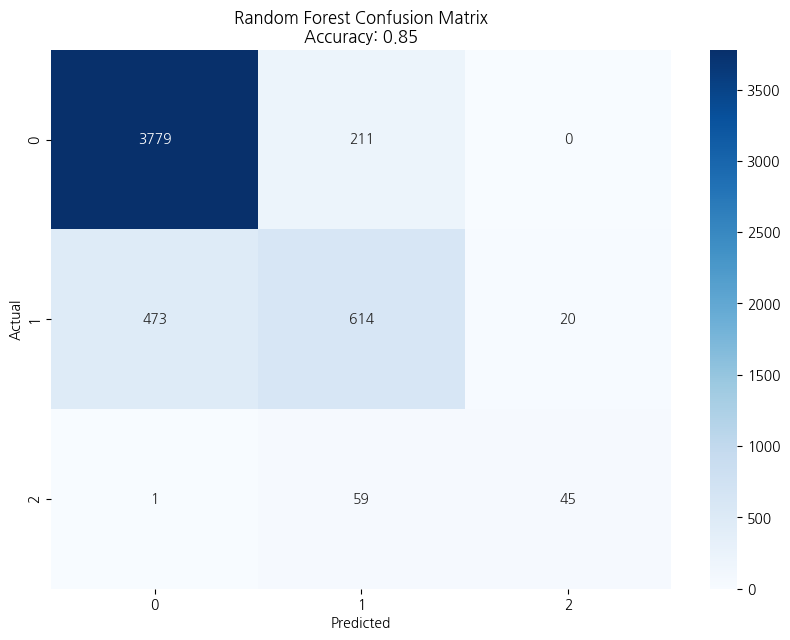

In [27]:
# Random Forest
rf_classifier = RandomForestClassifier(n_estimators=60, random_state=11)
evaluate_model(rf_classifier, 'Random Forest')

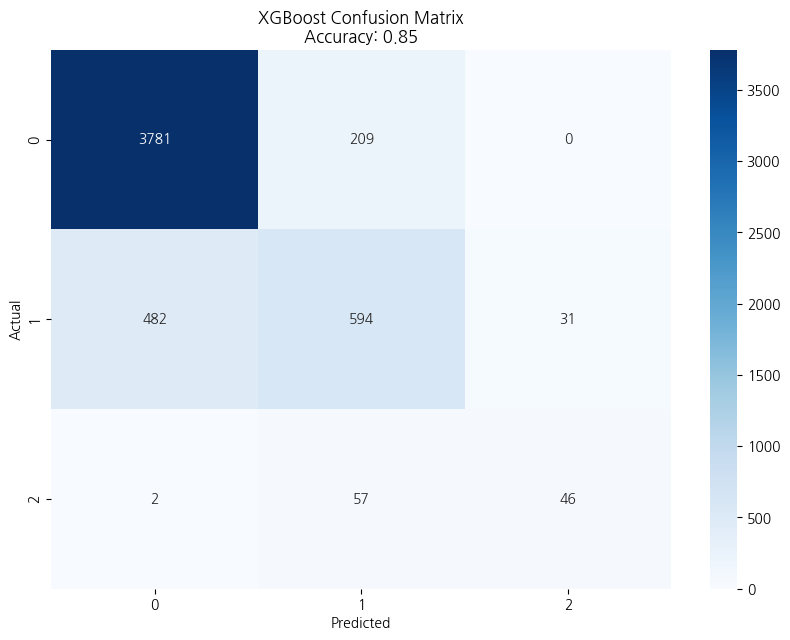

In [28]:
# XGBoost
xgb_classifier = XGBClassifier(eval_metric='logloss', random_state=11)
evaluate_model(xgb_classifier, 'XGBoost')

In [29]:
# 성능 데이터프레임 생성
performance_class12 = pd.DataFrame(performance_list)
print(performance_class12)

           Model Class  Accuracy  Precision    Recall  F1-Score  Support
0  Random Forest     0  0.853133   0.888549  0.947118  0.916899   3990.0
1  Random Forest     1  0.853133   0.694570  0.554652  0.616775   1107.0
2  Random Forest     2  0.853133   0.692308  0.428571  0.529412    105.0
3        XGBoost     0  0.849865   0.886518  0.947619  0.916051   3990.0
4        XGBoost     1  0.849865   0.690698  0.536585  0.603965   1107.0
5        XGBoost     2  0.849865   0.597403  0.438095  0.505495    105.0
